In [1]:
import statsmodels.stats.multitest as stat
import pandas as pd
import matplotlib.pyplot as plt
from qmplot import manhattanplot
from typing import Tuple
from scipy import stats
import numpy as np

In [31]:
def manhattan_qq_plot(dataframe: pd.DataFrame, model: str, trait: str) -> Tuple[plt.Figure, plt.Axes]:
    """
    Generate a Manhattan plot and QQ plot based on the given dataframe, model, and trait.

    Args:
        dataframe (pd.DataFrame): Input dataframe containing the necessary data.
        model (str): Model type ('GLM' or other).
        trait (str): Trait type ('simple' or other).

    Returns:
        Tuple[plt.Figure, plt.Axes]: A tuple containing the generated figure and axes objects.
    """
    # Set suggestiveline based on trait type
    if trait == 'simple' or trait == 'simple generated':
        suggestiveline = 0.1
    else:
        suggestiveline = 0.05

    # Generate Manhattan plot
    if model == 'GLM':
        # Generate Manhattan plot for GLM model
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), facecolor="w", edgecolor="k")
        ax1 = manhattanplot(data=dataframe,
                            suggestiveline=suggestiveline,
                            marker=".",
                            title=f"{model} {trait} trait",
                            sign_marker_color="r",
                            xlabel="Chr",
                            chrom="#CHROM",
                            pv='P.value_BY',
                            is_annotate_topsnp=True,
                            text_kws={"fontsize": 12},
                            ax=ax1)
        # Calculate expected quantiles
        expected_quantiles = -np.log10(np.linspace(1 / len(dataframe['P']), 1, len(dataframe['P'])))

        # Calculate observed quantiles based on p-value
        observed_quantiles = -np.log10(np.sort(dataframe['P']))
    elif model == "MVLMM":
        # Generate Manhattan plot for MVLMM model
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), facecolor="w", edgecolor="k")
        ax1 = manhattanplot(data=dataframe,
                            suggestiveline=suggestiveline,
                            marker=".",
                            title=f"{model} {trait} trait",
                            sign_marker_color="r",
                            xlabel="chr",
                            chrom="chr",
                            pos="ps",
                            snp='rs',
                            pv='P.value_BY',
                            is_annotate_topsnp=True,
                            text_kws={"fontsize": 12},
                            ax=ax1)
        ax1.set_ylim(bottom=0)
        # Calculate expected quantiles
        expected_quantiles = -np.log10(np.linspace(1 / len(dataframe['p_score']), 1, len(dataframe['p_score'])))

        # Calculate observed quantiles based on p-value
        observed_quantiles = -np.log10(np.sort(dataframe['p_score']))

    else:
        # Generate Manhattan plot for other models
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), facecolor="w", edgecolor="k")
        ax1 = manhattanplot(data=dataframe,
                            suggestiveline=suggestiveline,
                            marker=".",
                            chrom="Chr",
                            pos="Pos",
                            title=f"{model} {trait} trait",
                            sign_marker_color="r",
                            snp="SNP",
                            xlabel="Chr",
                            pv='P.value_BY',
                            is_annotate_topsnp=True,
                            text_kws={"fontsize": 12},
                            ax=ax1)
        # Calculate expected quantiles
        expected_quantiles = -np.log10(np.linspace(1 / len(dataframe['P.value']), 1, len(dataframe['P.value'])))

        # Calculate observed quantiles based on p-value
        observed_quantiles = -np.log10(np.sort(dataframe['P.value']))

    # Plot QQ plot on the second subplot
    ax2.scatter(expected_quantiles, observed_quantiles)
    ax2.plot([min(expected_quantiles), max(expected_quantiles)],
             [min(expected_quantiles), max(expected_quantiles)], color='red', linestyle='--')
    ax2.set_xlabel('Expected Quantiles')
    ax2.set_ylabel('Observed Quantiles')
    ax2.set_title(f'QQ Plot {model} {trait} trait')

    return fig, (ax1, ax2)

In [3]:
# Function to combine 'chr' and 'ps' columns into a single string
def combine_columns(row):
    return str(row['chr']) + '_' + str(row['ps'])

## BLINK complex trait

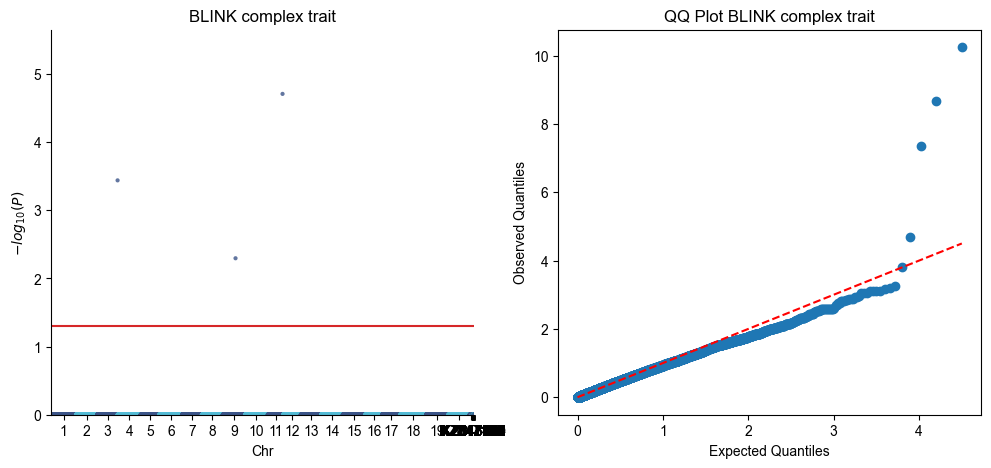

In [4]:
# Read the GWAS results file into a pandas DataFrame
df_soy_complex_b = pd.read_table('results/BLINK_complex/GAPIT.Association.GWAS_Results.BLINK.pheno.csv', sep=',')

# Apply the FDR correction to the 'P.value' column and add the corrected values to a new column 'P.value_BY'
df_soy_complex_b['P.value_BY'] = stat.fdrcorrection(pvals=df_soy_complex_b['P.value'],
                                                   alpha=0.05,
                                                   method='negcorr',
                                                   is_sorted=False)[1]

# Generate a Manhattan plot and QQ plot using the 'df_soy_complex_b' DataFrame, with 'BLINK' as the plot label and 'complex' as an additional identifier
manhattan_qq_plot(df_soy_complex_b, 'BLINK', 'complex');

Let's see which SNPs have a P-value with Benjamini-Yetkutieli correction less than 0.05

In [5]:
#Let's see what SNPs were selected
df_soy_complex_b_005 = df_soy_complex_b.loc[df_soy_complex_b['P.value_BY'] < 0.05]
df_soy_complex_b_005

,SNP,Chr,Pos,P.value,MAF,nobs,H&B.P.Value,Effect,P.value_BY
4413,4414,3,45355483,2.105178e-09,0.139175,97,0.000033,152.184998,0.000365
13038,13039,9,28490006,4.386478e-08,0.221649,97,0.000463,105.772036,0.005067
16482,16483,11,33243330,5.672423e-11,0.113402,97,0.000002,-148.898929,0.000020


In [6]:
# Create a new DataFrame 'df_soy_complex_b_annot' from 'df_soy_complex_b_005' containing only the 'Chr' and 'Pos' columns
df_soy_complex_b_annot = df_soy_complex_b_005[['Chr', 'Pos']].copy()

# Create a new column 'Pos-' by subtracting 500 from the 'Pos' column values
df_soy_complex_b_annot['Pos-'] = df_soy_complex_b_annot['Pos'] - 500

# Create a new column 'Pos+' by adding 500 to the 'Pos' column values
df_soy_complex_b_annot['Pos+'] = df_soy_complex_b_annot['Pos'] + 500

# Remove the 'Pos' column from 'df_soy_complex_b_annot'
df_soy_complex_b_annot.drop('Pos', axis=1, inplace=True)

# Save 'df_soy_complex_b_annot' as a tab-separated file 'blink_complex.bed' without headers and row indices
df_soy_complex_b_annot.to_csv('for_annotation/blink_complex.bed', header=False, index=False, sep='\t')

### BLINK complex trait generated data

/Users/iskys/venv/lib/python3.9/site-packages/qmplot/modules/_manhattan.py:346: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin=min(y), ymax=1.2 * max(y))


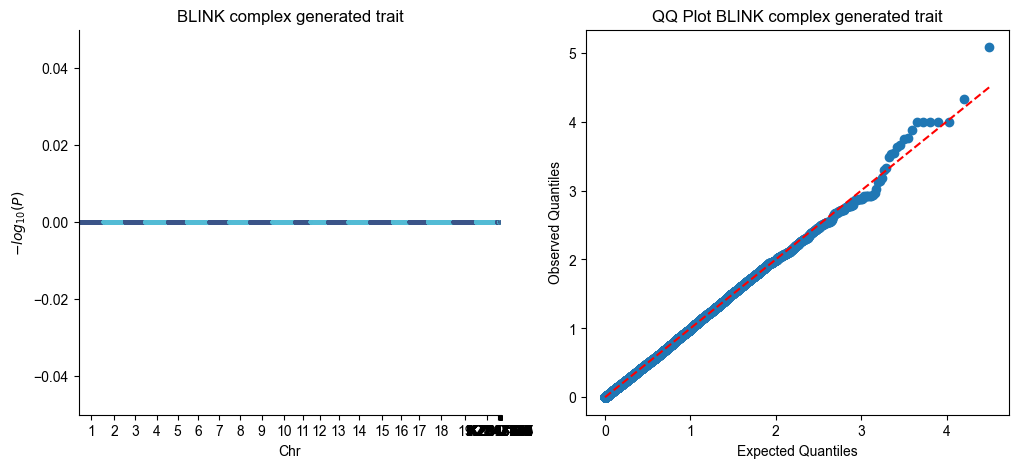

In [7]:
# Read the GWAS results file into a pandas DataFrame
df_soy_complex_b_gen = pd.read_table('results/BLINK_complex_gen/GAPIT.Association.GWAS_Results.BLINK.gen_pheno.csv', sep=',')

# Perform false discovery rate correction on the 'P.value' column and add the corrected values as 'P.value_BY'
df_soy_complex_b_gen['P.value_BY'] = stat.fdrcorrection(pvals=df_soy_complex_b_gen['P.value'], 
                                                       alpha=0.05, 
                                                       method='negcorr', 
                                                       is_sorted=False)[1]

# Generate a Manhattan plot and QQ plot using the DataFrame 'df_soy_complex_b_gen'
manhattan_qq_plot(df_soy_complex_b_gen, 'BLINK', 'complex generated');


Great, no significant SNPs were found in the generated data

## BLINK simple trait

/Users/iskys/venv/lib/python3.9/site-packages/qmplot/modules/_manhattan.py:346: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin=min(y), ymax=1.2 * max(y))


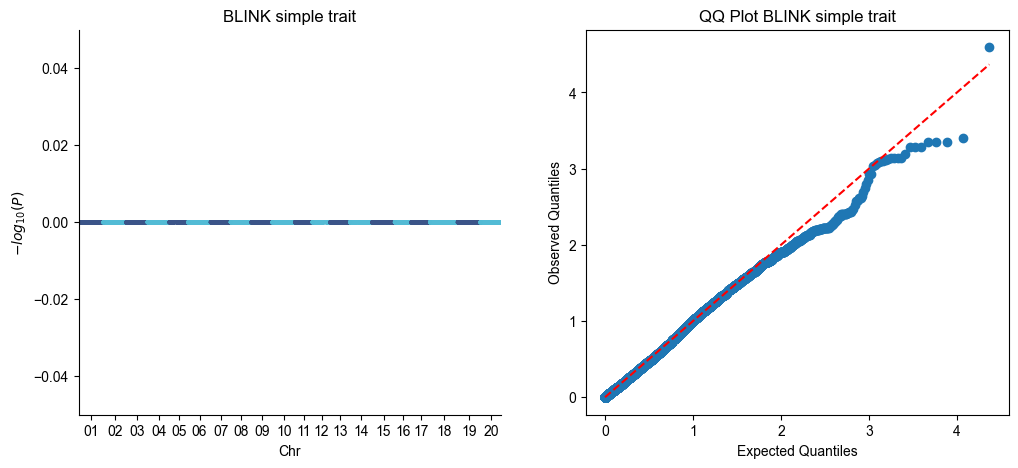

In [8]:
# Read data from the specified file into a DataFrame using pandas
df_soy_simple_b = pd.read_table('results/BLINK_simple/GAPIT.Association.GWAS_Results.BLINK.Leu.csv', sep=',')

# Apply False Discovery Rate (FDR) correction to the 'P.value' column and store the corrected p-values in a new column 'P.value_BY'
df_soy_simple_b['P.value_BY'] = stat.fdrcorrection(pvals=df_soy_simple_b['P.value'], 
                                                  alpha=0.05, 
                                                  method='negcorr', 
                                                  is_sorted=False)[1]

# Remove non-numeric characters from the 'Chr' column using regular expression and update the column in the DataFrame
df_soy_simple_b['Chr'] = df_soy_simple_b['Chr'].str.replace('[^0-9]', '', regex=True)

# Generate a Manhattan plot and a QQ plot using the 'df_soy_simple_b' DataFrame
manhattan_qq_plot(df_soy_simple_b, 'BLINK', 'simple');

In [9]:
#Let's see what SNPs were selected
df_soy_simple_b_01 = df_soy_simple_b.loc[df_soy_simple_b['P.value_BY'] < 0.1]
df_soy_simple_b_01

,SNP,Chr,Pos,P.value,MAF,nobs,H&B.P.Value,Effect,P.value_BY


In [10]:
# Create a new DataFrame, 'df_soy_simple_b_annot', with columns 'Chr' and 'Pos' copied from 'df_soy_simple_b_01'
df_soy_simple_b_annot = df_soy_simple_b_01[['Chr', 'Pos']].copy()

# Add a new column 'Pos-' to 'df_soy_simple_b_annot' by subtracting 500 from 'Pos'
df_soy_simple_b_annot['Pos-'] = df_soy_simple_b_annot['Pos'] - 500

# Add a new column 'Pos+' to 'df_soy_simple_b_annot' by adding 500 to 'Pos'
df_soy_simple_b_annot['Pos+'] = df_soy_simple_b_annot['Pos'] + 500

# Remove the 'Pos' column from 'df_soy_simple_b_annot'
df_soy_simple_b_annot.drop('Pos', axis=1, inplace=True)

# Save 'df_soy_simple_b_annot' as a tab-separated BED file without header and index to 'for_annotation/blink_simple.bed'
df_soy_simple_b_annot.to_csv('for_annotation/blink_simple.bed', header=False, index=False, sep='\t')

### BLINK simple trait generated data

/Users/iskys/venv/lib/python3.9/site-packages/qmplot/modules/_manhattan.py:346: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin=min(y), ymax=1.2 * max(y))


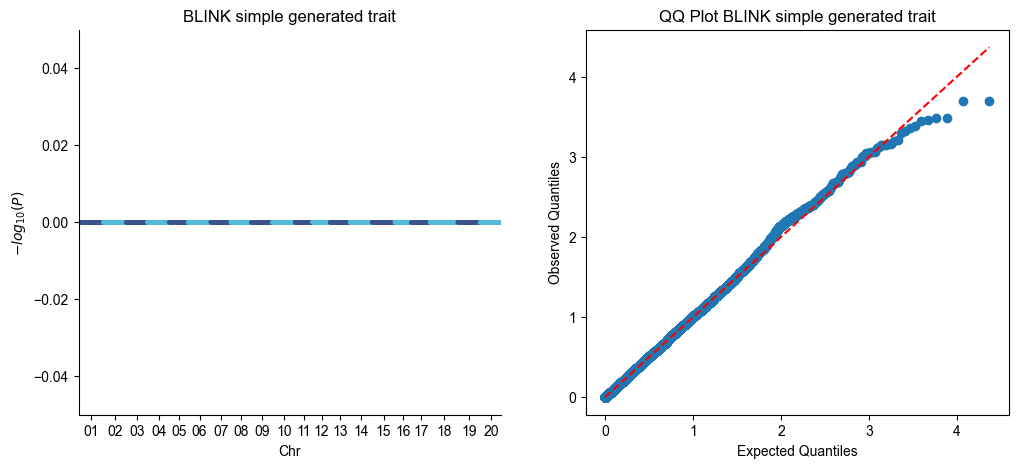

In [11]:
# Read the GWAS results file for BLINK association analysis of Leu in soybean
df_soy_simple_b_gen = pd.read_table('results/BLINK_simple_gen/GAPIT.Association.GWAS_Results.BLINK.Leu.csv', sep=',')

# Apply false discovery rate correction to the p-values and store them in a new column 'P.value_BY'
df_soy_simple_b_gen['P.value_BY'] = stat.fdrcorrection(pvals=df_soy_simple_b_gen['P.value'], 
                                                     alpha=0.05, 
                                                     method='negcorr', 
                                                     is_sorted=False)[1]

# Remove non-numeric characters from the 'Chr' column
df_soy_simple_b_gen['Chr'] = df_soy_simple_b_gen['Chr'].str.replace('[^0-9]', '', regex=True)

# Generate a Manhattan plot and QQ plot using the modified dataframe
manhattan_qq_plot(df_soy_simple_b_gen, 'BLINK', 'simple generated');

## FarmCPU complex trait

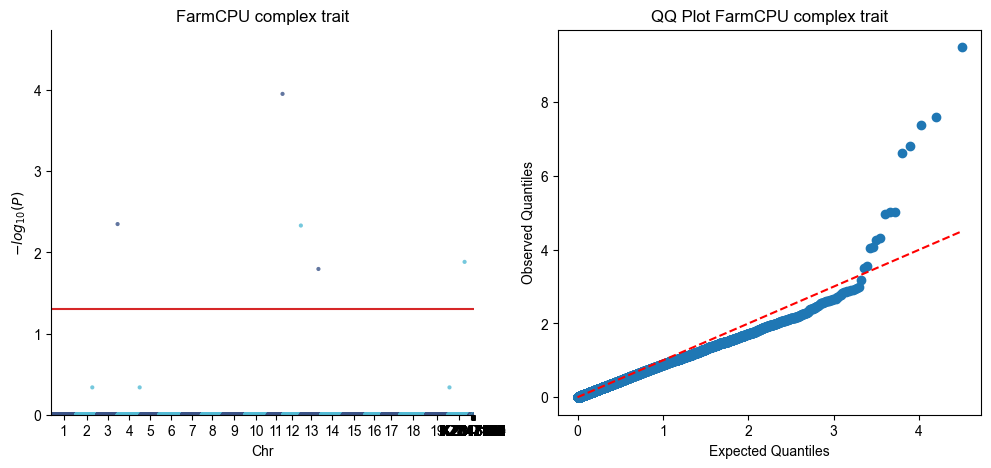

In [12]:
# Read the GWAS results file into a DataFrame
df_soy_complex_f = pd.read_table('results/FarmCPU_complex/GAPIT.Association.GWAS_Results.FarmCPU.pheno.csv', sep=',')

# Apply false discovery rate (FDR) correction to the P-values and store the corrected values
df_soy_complex_f['P.value_BY'] = stat.fdrcorrection(pvals=df_soy_complex_f['P.value'], 
                                                   alpha=0.05, 
                                                   method='negcorr', 
                                                   is_sorted=False)[1]

# Generate a Manhattan plot and QQ plot using the modified DataFrame
manhattan_qq_plot(df_soy_complex_f, 'FarmCPU', 'complex');

In [13]:
#Let's see what SNPs were selected
df_soy_complex_f_005 = df_soy_complex_f.loc[df_soy_complex_f['P.value_BY'] < 0.05]
df_soy_complex_f_005

,SNP,Chr,Pos,P.value,MAF,nobs,H&B.P.Value,Effect,P.value_BY
4413,4414,3,45355483,2.582480e-08,0.139175,97,0.000409,103.164183,0.004475
16482,16483,11,33243330,3.213935e-10,0.113402,97,0.000010,-106.232198,0.000111
17485,17486,12,39996708,4.037204e-08,0.164948,97,0.000426,-72.724239,0.004664
18908,18909,13,39682867,2.308432e-07,0.139175,97,0.001462,-72.267450,0.016000
30543,30544,20,36271980,1.509955e-07,0.474227,97,0.001196,37.666141,0.013082


In [14]:
# Create a copy of the 'df_soy_complex_f_005' DataFrame with only the 'Chr' and 'Pos' columns
df_soy_complex_f_annot = df_soy_complex_f_005[['Chr', 'Pos']].copy()

# Calculate the 'Pos-' column by subtracting 500 from the 'Pos' column
df_soy_complex_f_annot['Pos-'] = df_soy_complex_f_annot['Pos'] - 500

# Calculate the 'Pos+' column by adding 500 to the 'Pos' column
df_soy_complex_f_annot['Pos+'] = df_soy_complex_f_annot['Pos'] + 500

# Drop the 'Pos' column from the DataFrame
df_soy_complex_f_annot.drop('Pos', axis=1, inplace=True)

# Save the modified DataFrame to a BED file for annotation, without header and tab-separated
df_soy_complex_f_annot.to_csv('for_annotation/farmcpu_complex.bed', header=False, index=False, sep='\t')

### FarmCPU complex trait generated data

/Users/iskys/venv/lib/python3.9/site-packages/qmplot/modules/_manhattan.py:346: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin=min(y), ymax=1.2 * max(y))


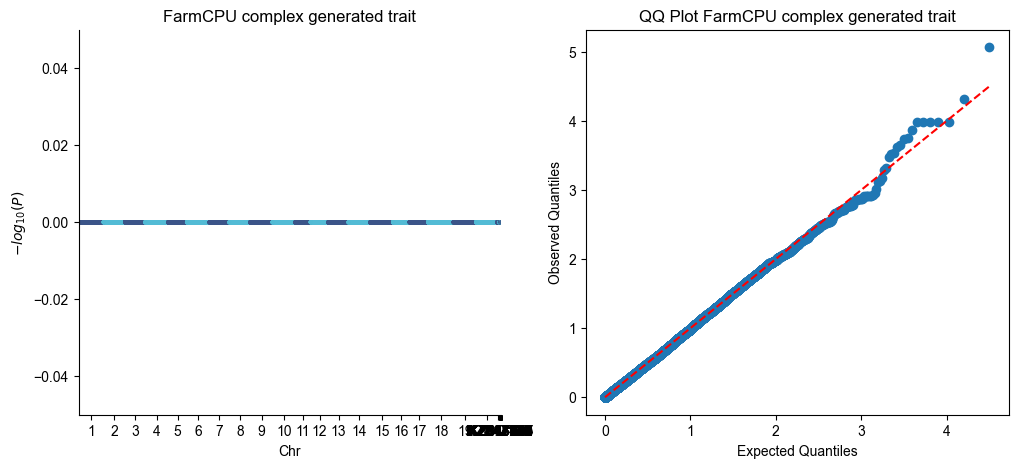

In [15]:
# Read GWAS results from a CSV file into a DataFrame
df_soy_complex_f_gen = pd.read_table('results/FarmCPU_complex_gen/GAPIT.Association.GWAS_Results.FarmCPU.gen_pheno.csv', sep=',')

# Apply False Discovery Rate (FDR) correction to the 'P.value' column using the stat.fdrcorrection function
# The corrected p-values are stored in a new column 'P.value_BY'
df_soy_complex_f_gen['P.value_BY'] = stat.fdrcorrection(pvals=df_soy_complex_f_gen['P.value'],
                                                       alpha=0.05,
                                                       method='negcorr',
                                                       is_sorted=False)[1]

# Generate a Manhattan plot and QQ plot using the 'manhattan_qq_plot' function
# Pass the 'df_soy_simple_f_gen' DataFrame, the analysis method ('FarmCPU'), and a plot title ('complex generated')
manhattan_qq_plot(df_soy_complex_f_gen, 'FarmCPU', 'complex generated');

## FarmCPU simple trait

/Users/iskys/venv/lib/python3.9/site-packages/qmplot/modules/_manhattan.py:346: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin=min(y), ymax=1.2 * max(y))


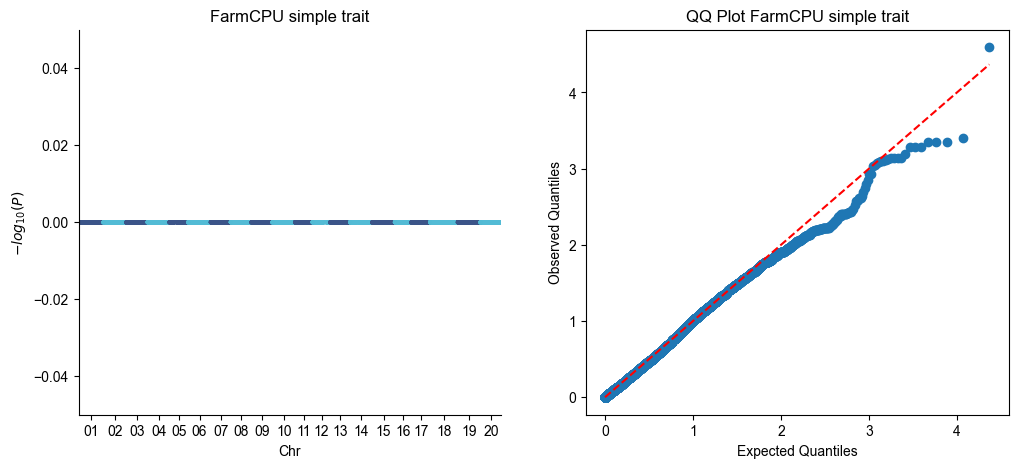

In [16]:
# Read data from a CSV file into a pandas DataFrame
df_soy_simple_f = pd.read_table('results/FarmCPU_simple/GAPIT.Association.GWAS_Results.FarmCPU.Leu.csv', sep=',')

# Apply false discovery rate correction to the p-values in the DataFrame
df_soy_simple_f['P.value_BY'] = stat.fdrcorrection(pvals=df_soy_simple_f['P.value'], 
                                                   alpha=0.05, 
                                                   method='negcorr', 
                                                   is_sorted=False)[1]

# Remove non-numeric characters from the 'Chr' column in the DataFrame
df_soy_simple_f['Chr'] = df_soy_simple_f['Chr'].str.replace('[^0-9]', '', regex=True)

# Generate a Manhattan and QQ plot using the modified DataFrame
manhattan_qq_plot(df_soy_simple_f, 'FarmCPU', 'simple');

In [17]:
#Let's see what SNPs were selected
df_soy_simple_f_01 = df_soy_simple_f.loc[df_soy_simple_f['P.value_BY'] < 0.1]
df_soy_simple_f_01

,SNP,Chr,Pos,P.value,MAF,nobs,H&B.P.Value,Effect,P.value_BY


In [18]:
# Create a new DataFrame 'df_soy_simple_f_annot' by copying the columns 'Chr' and 'Pos' from 'df_soy_simple_f_01'
df_soy_simple_f_annot = df_soy_simple_f_01[['Chr', 'Pos']].copy()

# Create a new column 'Pos-' in 'df_soy_simple_f_annot' by subtracting 500 from the 'Pos' column
df_soy_simple_f_annot['Pos-'] = df_soy_simple_f_annot['Pos'] - 500

# Create a new column 'Pos+' in 'df_soy_simple_f_annot' by adding 500 to the 'Pos' column
df_soy_simple_f_annot['Pos+'] = df_soy_simple_f_annot['Pos'] + 500

# Drop the 'Pos' column from 'df_soy_simple_f_annot'
df_soy_simple_f_annot.drop('Pos', axis=1, inplace=True)

# Save the 'df_soy_simple_f_annot' DataFrame to a BED file named 'for_annotation/farmcpu_simple.bed'
# The file will be saved without a header and tab-separated values
df_soy_simple_f_annot.to_csv('for_annotation/farmcpu_simple.bed', header=False, index=False, sep='\t')

### FarmCPU simple trait generated data

/Users/iskys/venv/lib/python3.9/site-packages/qmplot/modules/_manhattan.py:346: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin=min(y), ymax=1.2 * max(y))


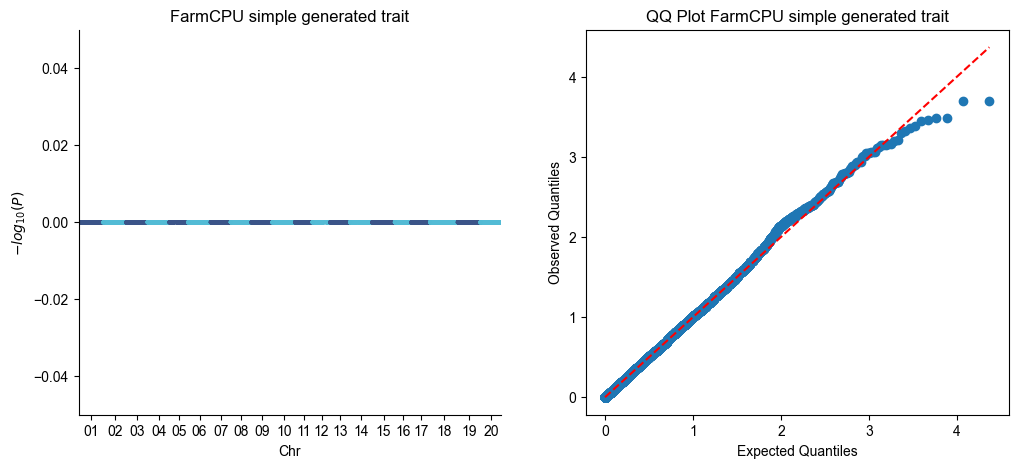

In [19]:
# Read GWAS results from the FarmCPU analysis for soybean
df_soy_simple_f_gen = pd.read_table('results/FarmCPU_simple_gen/GAPIT.Association.GWAS_Results.FarmCPU.Leu.csv', sep=',')

# Apply FDR correction to the p-values using Benjamini-Hochberg method
df_soy_simple_f_gen['P.value_BY'] = stat.fdrcorrection(pvals=df_soy_simple_f_gen['P.value'], 
                                                      alpha=0.05, 
                                                      method='negcorr', 
                                                      is_sorted=False)[1]

# Remove non-numeric characters from the 'Chr' column
df_soy_simple_f_gen['Chr'] = df_soy_simple_f_gen['Chr'].str.replace('[^0-9]', '', regex=True)

# Generate Manhattan and QQ plots using the modified DataFrame
manhattan_qq_plot(df_soy_simple_f_gen, 'FarmCPU', 'simple generated');

## SUPER complex trait

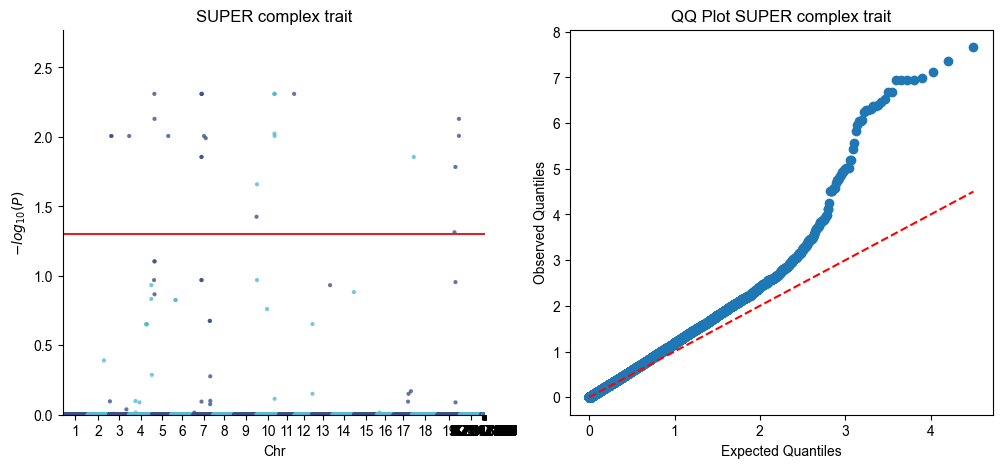

In [20]:
# Read GWAS results from a CSV file into a pandas DataFrame
df_soy_complex_s = pd.read_table('results/SUPER_complex/GAPIT.Association.GWAS_Results.SUPER.pheno.csv', sep=',')

# Apply false discovery rate correction to the p-values column
df_soy_complex_s['P.value_BY'] = stat.fdrcorrection(pvals=df_soy_complex_s['P.value'], 
                                                    alpha=0.05, 
                                                    method='negcorr', 
                                                    is_sorted=False)[1]

# Generate a Manhattan plot and QQ plot for the 'SUPER' complex association
manhattan_qq_plot(df_soy_complex_s, 'SUPER', 'complex');

In [21]:
#Let's see what SNPs were selected
df_soy_complex_s_005 = df_soy_complex_s.loc[df_soy_complex_s['P.value_BY'] < 0.05]
df_soy_complex_s_005

,SNP,Chr,Pos,P.value,MAF,nobs,H&B.P.Value,Effect,P.value_BY
3025,3026,3,4891054,4.335992e-07,0.097938,92,0.000901,NaN,0.009853
3026,3027,3,4891056,4.335992e-07,0.097938,92,0.000901,NaN,0.009853
4413,4414,3,45355483,5.117551e-07,0.139175,92,0.000901,NaN,0.009853
6778,6779,5,4355701,4.487133e-08,0.128866,92,0.000448,NaN,0.004903
6802,6803,5,4684569,2.140147e-07,0.154639,92,0.000678,NaN,0.007417
7397,7398,5,35824337,5.068382e-07,0.108247,92,0.000901,NaN,0.009853
10193,10194,7,17555663,8.851254e-07,0.180412,92,0.001274,NaN,0.013943
10194,10195,7,17555788,8.851254e-07,0.180412,92,0.001274,NaN,0.013943
10208,10209,7,17902694,1.131762e-07,0.108247,92,0.000448,NaN,0.004903
10209,10210,7,17902749,1.131762e-07,0.108247,92,0.000448,NaN,0.004903


In [22]:
df_soy_complex_s_annot = df_soy_complex_s_005[['Chr', 'Pos']].copy()
df_soy_complex_s_annot['Pos-'] = df_soy_complex_s_annot['Pos'] - 500
df_soy_complex_s_annot['Pos+'] = df_soy_complex_s_annot['Pos'] + 500
df_soy_complex_s_annot.drop('Pos', axis=1, inplace=True)
df_soy_complex_s_annot.to_csv('for_annotation/super_complex.bed', header=False, index=False, sep='\t')

### SUPER complex trait generated data

/Users/iskys/venv/lib/python3.9/site-packages/qmplot/modules/_manhattan.py:346: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin=min(y), ymax=1.2 * max(y))


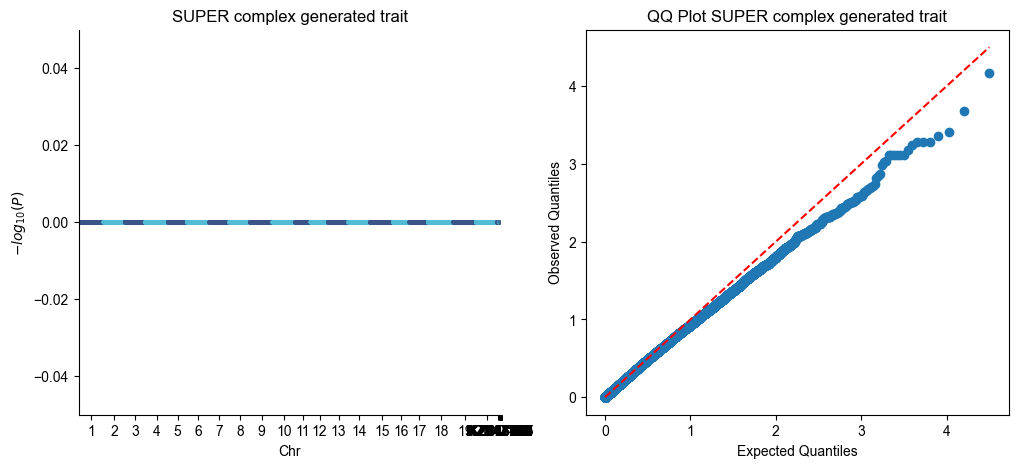

In [23]:
# Read the data file 'GAPIT/SUPER_complex_gen/GAPIT.Association.GWAS_Results.SUPER.gen_pheno.csv' into a pandas DataFrame
df_soy_complex_s_gen = pd.read_table('results/SUPER_complex_gen/GAPIT.Association.GWAS_Results.SUPER.gen_pheno.csv', sep=',')

# Perform multiple testing correction (Benjamini-Yekutieli method) on the 'P.value' column and store the corrected p-values in 'P.value_BY' column
df_soy_complex_s_gen['P.value_BY'] = stat.fdrcorrection(pvals=df_soy_complex_s_gen['P.value'], 
                                                       alpha=0.05, 
                                                       method='negcorr', 
                                                       is_sorted=False)[1]

# Generate a Manhattan and QQ plot for the 'SUPER' complex with the generated data
manhattan_qq_plot(df_soy_complex_s_gen, 'SUPER', 'complex generated');

## SUPER simple trait

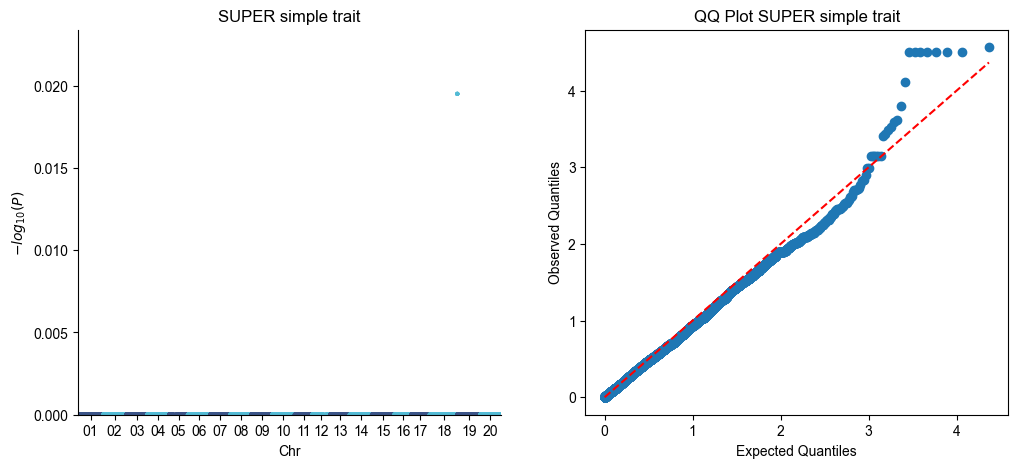

In [24]:
# Read GWAS results data from a CSV file
df_soy_simple_s = pd.read_table('results/SUPER_simple/GAPIT.Association.GWAS_Results.SUPER.Leu.csv', sep=',')

# Apply FDR correction to the p-values and store the corrected values in a new column
df_soy_simple_s['P.value_BY'] = stat.fdrcorrection(pvals=df_soy_simple_s['P.value'],
                                                  alpha=0.05,
                                                  method='negcorr',
                                                  is_sorted=False)[1]

# Clean up the 'Chr' column by removing non-numeric characters
df_soy_simple_s['Chr'] = df_soy_simple_s['Chr'].str.replace('[^0-9]', '', regex=True)

# Generate a Manhattan-QQ plot using the processed data
manhattan_qq_plot(df_soy_simple_s, 'SUPER', 'simple');

In [25]:
#Let's see what SNPs were selected
df_soy_simple_s.loc[df_soy_simple_s['P.value_BY'] < 0.1] #nothing found here...

,SNP,Chr,Pos,P.value,MAF,nobs,H&B.P.Value,Effect,P.value_BY


### SUPER simple trait generated data

/Users/iskys/venv/lib/python3.9/site-packages/qmplot/modules/_manhattan.py:346: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin=min(y), ymax=1.2 * max(y))


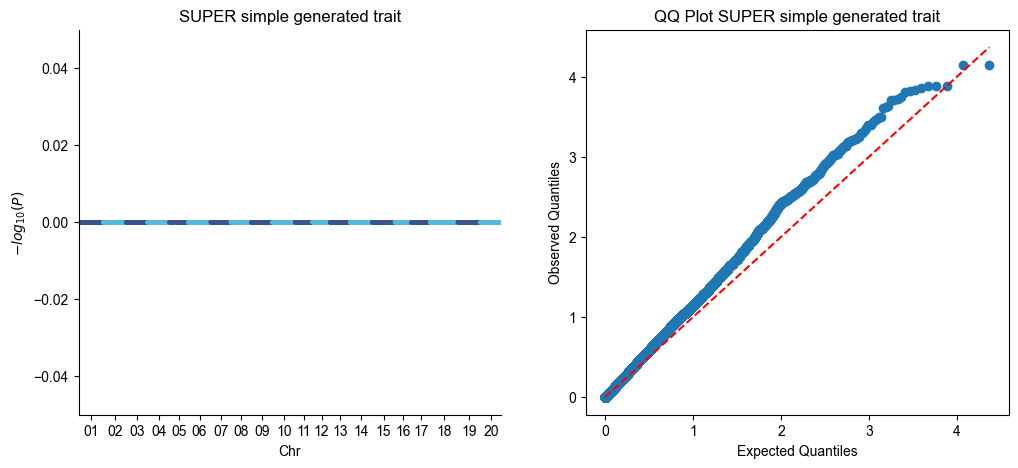

In [26]:
# Read GWAS results from a CSV file
df_soy_simple_s_gen = pd.read_table('results/SUPER_simple_gen/GAPIT.Association.GWAS_Results.SUPER.Leu.csv', sep=',')

# Perform false discovery rate correction on p-values
df_soy_simple_s_gen['P.value_BY'] = stat.fdrcorrection(pvals=df_soy_simple_s_gen['P.value'],
                                                      alpha=0.05,
                                                      method='negcorr',
                                                      is_sorted=False)[1]

# Clean up the 'Chr' column by removing non-numeric characters
df_soy_simple_s_gen['Chr'] = df_soy_simple_s_gen['Chr'].str.replace('[^0-9]', '', regex=True)

# Generate a Manhattan plot and QQ plot for the GWAS results
manhattan_qq_plot(df_soy_simple_s_gen, 'SUPER', 'simple generated');

## GLM simple trait

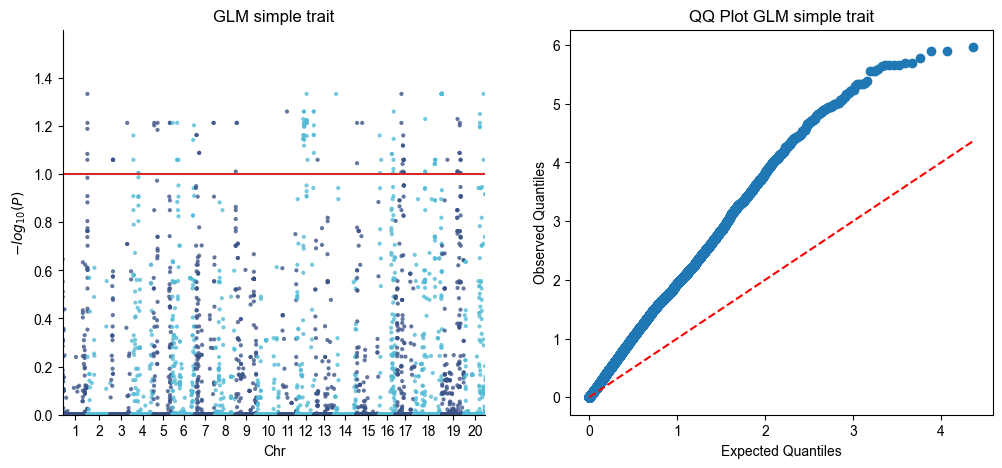

In [33]:
# Read the results from the 'results/plink_glm/simple_glm_result_chr.Leu.glm.linear' file into a DataFrame
df_soy_simple_g = pd.read_table('results/plink_glm/simple_glm_result.Leu.glm.linear', sep="\t")

# Apply the Benjamini-Yekutieli FDR correction to the 'P' values and store the corrected values in a new column 'P.value_BY'
df_soy_simple_g['P.value_BY'] = stat.fdrcorrection(pvals=df_soy_simple_g['P'],
                                                  alpha=0.05,
                                                  method='negcorr',
                                                  is_sorted=False)[1]

# Generate a Manhattan plot and QQ plot using the 'df_soy_simple_g' DataFrame, labeling it as 'GLM' and 'simple'
manhattan_qq_plot(df_soy_simple_g, 'GLM', 'simple');

In [34]:
#Let's see what SNPs were selected
df_soy_simple_g_01 = df_soy_simple_g.loc[df_soy_simple_g['P.value_BY'] < 0.1]
df_soy_simple_g_01

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,ERRCODE,P.value_BY
1254,1,55451641,.,G,A,A,ADD,242,0.929069,0.217879,4.26415,0.000029,.,0.082468
1256,1,55573886,.,C,T,T,ADD,242,0.940878,0.213626,4.40431,0.000016,.,0.064891
1258,1,55581083,.,A,G,G,ADD,242,0.903168,0.213338,4.23351,0.000033,.,0.087279
1262,1,55605372,.,T,C,C,ADD,242,0.996028,0.207584,4.79818,0.000003,.,0.046445
1263,1,55605442,.,C,T,T,ADD,242,0.949934,0.208223,4.56210,0.000008,.,0.061290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22719,20,34369312,.,T,C,C,ADD,242,1.036520,0.221916,4.67076,0.000005,.,0.056241
22720,20,34381866,.,A,C,C,ADD,240,1.411890,0.319967,4.41261,0.000015,.,0.063886
22721,20,34381881,.,T,C,C,ADD,240,1.420710,0.314788,4.51324,0.000010,.,0.061290
23066,20,42531505,.,C,G,G,ADD,241,-1.743020,0.357726,-4.87249,0.000002,.,0.046445


In [38]:
# Create a new DataFrame 'df_soy_simple_g_annot' from a subset of columns in 'df_soy_simple_g_01'
df_soy_simple_g_annot = df_soy_simple_g_01[['#CHROM', 'POS']].copy()

# Add a new column 'Pos-' to 'df_soy_simple_g_annot' by subtracting 500 from 'POS' column
df_soy_simple_g_annot['Pos-'] = df_soy_simple_g_annot['POS'] - 500

# Add a new column 'Pos+' to 'df_soy_simple_g_annot' by adding 500 to 'POS' column
df_soy_simple_g_annot['Pos+'] = df_soy_simple_g_annot['POS'] + 500

# Remove the 'POS' column from 'df_soy_simple_g_annot'
df_soy_simple_g_annot.drop('POS', axis=1, inplace=True)

# Write the contents of 'df_soy_simple_g_annot' to a tab-separated file 'glm_simple.bed' in the 'for_annotation' directory
df_soy_simple_g_annot.to_csv('for_annotation/glm_simple.bed', header=False, index=False, sep='\t')

### GLM simple trait generated data

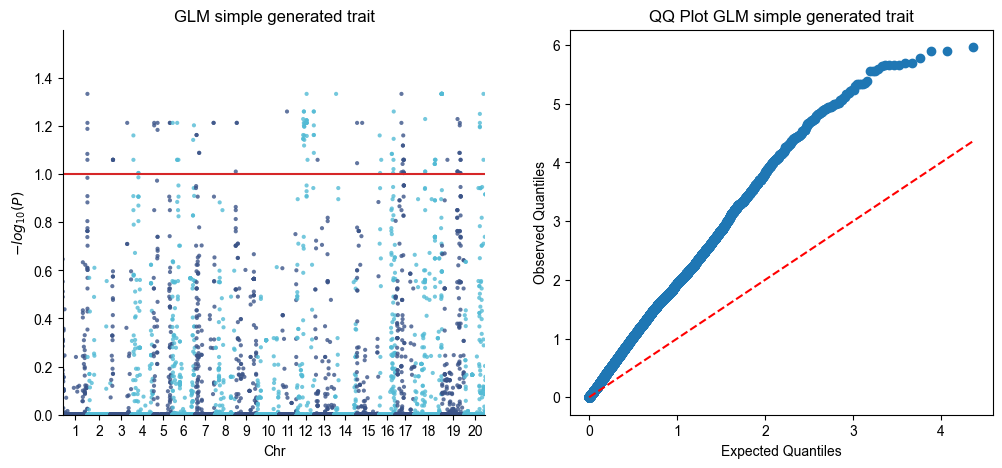

In [41]:
# Read the data from a file into a DataFrame
df_soy_simple_g_gen = pd.read_table('results/plink_glm/simple_glm_gen_result.Leu.glm.linear', sep="\t")

# Apply the Benjamini-Hochberg FDR correction to the p-values and add the corrected values as a new column
df_soy_simple_g_gen['P.value_BY'] = stat.fdrcorrection(pvals=df_soy_simple_g_gen['P'], 
                                                      alpha=0.05, 
                                                      method='negcorr', 
                                                      is_sorted=False)[1]

# Generate a Manhattan and QQ plot for the 'GLM' analysis with the 'simple generated' label
manhattan_qq_plot(df_soy_simple_g, 'GLM', 'simple generated');

## GLM complex trait

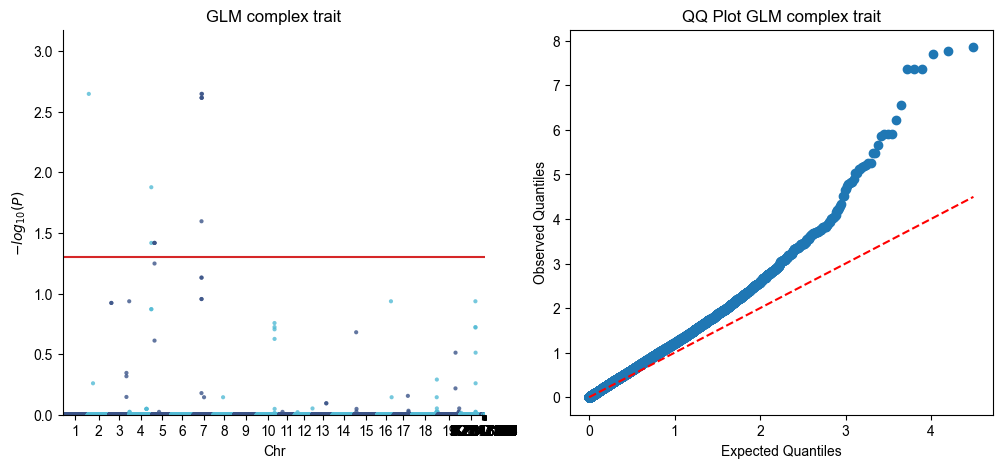

In [43]:
# Read the data from the file 'complex_glm_result.PHENO1.glm.linear' using pandas
df_soy_complex_g = pd.read_table('results/plink_glm/complex_glm_result.pheno.glm.linear', sep="\t")

# Remove rows with any missing values from the DataFrame
df_soy_complex_g = df_soy_complex_g.dropna(how="any", axis=0)

# Apply false discovery rate correction to the 'P' values and store the corrected values in a new column 'P.value_BY'
df_soy_complex_g['P.value_BY'] = stat.fdrcorrection(pvals=df_soy_complex_g['P'], 
                                                   alpha=0.05, 
                                                   method='negcorr', 
                                                   is_sorted=False)[1]

# Generate a Manhattan plot and a QQ plot using the DataFrame 'df_soy_complex_g'
manhattan_qq_plot(df_soy_complex_g, 'GLM', 'complex');

In [46]:
#Let's see what SNPs were selected
df_soy_complex_g_005 = df_soy_complex_g.loc[df_soy_complex_g['P.value_BY'] < 0.05]
df_soy_complex_g_005

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,ERRCODE,P.value_BY
1324,2,2413639,.,T,A,T,ADD,69,231.835,36.3810,6.37242,1.976120e-08,.,0.002255
6379,4,49624157,.,G,A,G,ADD,94,133.695,24.0820,5.55167,2.715930e-07,.,0.013282
6380,4,49624172,.,T,C,T,ADD,94,125.148,24.1933,5.17286,1.341110e-06,.,0.038258
6741,5,4684401,.,T,A,A,ADD,79,207.391,39.3825,5.26608,1.226310e-06,.,0.038258
6742,5,4684477,.,A,T,T,ADD,79,207.391,39.3825,5.26608,1.226310e-06,.,0.038258
6744,5,4684643,.,T,A,A,ADD,84,164.749,31.4701,5.23511,1.246270e-06,.,0.038258
10099,7,17511124,.,G,C,C,ADD,96,150.987,24.4453,6.17652,1.661220e-08,.,0.002255
10100,7,17518806,.,T,C,C,ADD,87,159.815,29.5888,5.40119,5.924080e-07,.,0.025350
10117,7,17902694,.,G,A,A,ADD,92,171.604,28.6512,5.98943,4.255580e-08,.,0.002428
10118,7,17902749,.,T,G,G,ADD,92,171.604,28.6512,5.98943,4.255580e-08,.,0.002428


In [47]:
# Create a new DataFrame with selected columns from df_soy_complex_g_005
df_soy_complex_g_annot = df_soy_complex_g_005[['#CHROM', 'POS']].copy()

# Calculate the 'Pos-' column by subtracting 500 from the 'POS' column
df_soy_complex_g_annot['Pos-'] = df_soy_complex_g_annot['POS'] - 500

# Calculate the 'Pos+' column by adding 500 to the 'POS' column
df_soy_complex_g_annot['Pos+'] = df_soy_complex_g_annot['POS'] + 500

# Drop the 'POS' column from the DataFrame
df_soy_complex_g_annot.drop('POS', axis=1, inplace=True)

# Save the DataFrame as a tab-separated values (TSV) file without headers and index
df_soy_complex_g_annot.to_csv('for_annotation/glm_complex.bed', header=False, index=False, sep='\t')

### GLM complex trait generated data

/Users/iskys/venv/lib/python3.9/site-packages/qmplot/modules/_manhattan.py:346: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin=min(y), ymax=1.2 * max(y))


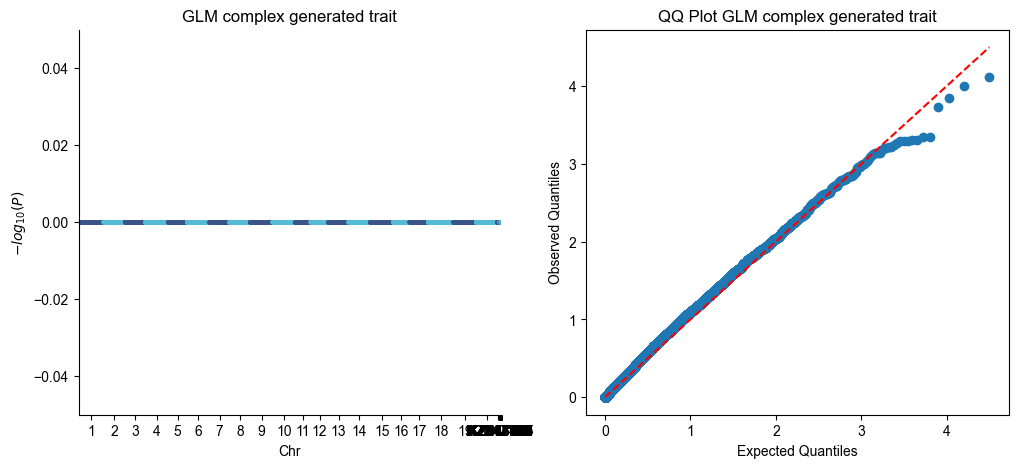

In [49]:
# Read the data from the specified file into a DataFrame
df_soy_complex_g_gen = pd.read_table('results/plink_glm/complex_glm_gen_result.gen_pheno.glm.linear', sep="\t")

# Remove rows with any missing values from the DataFrame
df_soy_complex_g_gen = df_soy_complex_g_gen.dropna(how="any", axis=0)

# Apply False Discovery Rate (FDR) correction to the 'P' values and store the corrected values in a new column
df_soy_complex_g_gen['P.value_BY'] = stat.fdrcorrection(pvals=df_soy_complex_g_gen['P'],
                                                       alpha=0.05,
                                                       method='negcorr',
                                                       is_sorted=False)[1]

# Generate a Manhattan and QQ plot using the modified DataFrame
manhattan_qq_plot(df_soy_complex_g_gen, 'GLM', 'complex generated');

### BSLMM simple trait for annotation

In [50]:
#Let's see what SNPs were selected
df_soy_simple_bslmm = pd.read_csv('results/GEMMA_BSLMM/simple/pip01_simple.dsv', sep='\t')
df_soy_simple_bslmm_002 = df_soy_simple_bslmm.loc[df_soy_simple_bslmm['gamma'] > 0.02]
df_soy_simple_bslmm_002

,chr,rs,ps,n_miss,alpha,beta,gamma,eff
0,12,.,1966701,4,-0.001641,-0.382695,0.03097,0.011852
1,2,.,13389864,0,-0.000086,-0.009477,0.02610,0.000247
2,10,.,31540259,3,-0.000193,-0.027316,0.02435,0.000665
3,3,.,17717709,0,-0.000079,-0.006156,0.02373,0.000146
4,15,.,29200526,0,-0.000147,-0.016670,0.02304,0.000384
5,1,.,49641969,0,-0.000015,-0.003052,0.02272,0.000069
6,12,.,2246393,2,0.001490,0.399996,0.02234,0.008936
7,13,.,24035355,1,-0.000117,-0.001542,0.02165,0.000033
8,18,.,51230770,2,0.000151,0.017887,0.02156,0.000386
9,16,.,27656811,0,0.001285,0.410898,0.02138,0.008785


In [51]:
# Creating a copy of the 'chr' and 'ps' columns from df_soy_simple_bslmm_002 DataFrame
df_soy_simple_bslmm_annot = df_soy_simple_bslmm_002[['chr', 'ps']].copy()

# Adding a new column 'Pos-' which subtracts 500 from the 'ps' column
df_soy_simple_bslmm_annot['Pos-'] = df_soy_simple_bslmm_annot['ps'] - 500

# Adding a new column 'Pos+' which adds 500 to the 'ps' column
df_soy_simple_bslmm_annot['Pos+'] = df_soy_simple_bslmm_annot['ps'] + 500

# Dropping the 'ps' column from df_soy_simple_bslmm_annot DataFrame
df_soy_simple_bslmm_annot.drop('ps', axis=1, inplace=True)

# Exporting the df_soy_simple_bslmm_annot DataFrame to a tab-separated BED file 'for_annotation/bslmm_simple.bed' without headers and indices
df_soy_simple_bslmm_annot.to_csv('for_annotation/bslmm_simple.bed', header=False, index=False, sep='\t')

### BSLMM complex trait for annotation

In [52]:
#Let's see what SNPs were selected
df_soy_complex_bslmm = pd.read_csv('results/GEMMA_BSLMM/complex/pip01_complex.dsv', sep='\t')
df_soy_complex_bslmm_002 = df_soy_complex_bslmm.loc[df_soy_complex_bslmm['gamma'] > 0.02]
df_soy_complex_bslmm_002

,chr,rs,ps,n_miss,alpha,beta,gamma,eff
0,7,10190,17511124,1,0.221906,104.85920,0.11703,12.271672
1,4,6435,49624157,3,-0.241362,-79.77792,0.07860,6.270545
2,4,6436,49624172,3,-0.227274,-58.00821,0.03772,2.188070
3,12,16840,6176386,4,-0.264355,-27.67916,0.02312,0.639942
4,18,27719,55469724,2,-0.168778,-37.99219,0.02270,0.862423
5,20,30409,34605587,2,-0.260948,-35.23038,0.02186,0.770136
6,19,29681,48403576,0,-0.266613,-35.36275,0.02101,0.742971
7,13,18559,31092569,0,0.247999,26.67985,0.02006,0.535198


In [53]:
# Copy the 'chr' and 'ps' columns from df_soy_complex_bslmm_002 into a new dataframe called df_soy_complex_bslmm_annot
df_soy_complex_bslmm_annot = df_soy_complex_bslmm_002[['chr', 'ps']].copy()

# Create a new column 'Pos-' in df_soy_complex_bslmm_annot by subtracting 500 from the 'ps' column
df_soy_complex_bslmm_annot['Pos-'] = df_soy_complex_bslmm_annot['ps'] - 500

# Create a new column 'Pos+' in df_soy_complex_bslmm_annot by adding 500 to the 'ps' column
df_soy_complex_bslmm_annot['Pos+'] = df_soy_complex_bslmm_annot['ps'] + 500

# Drop the 'ps' column from df_soy_complex_bslmm_annot
df_soy_complex_bslmm_annot.drop('ps', axis=1, inplace=True)

# Save the df_soy_complex_bslmm_annot dataframe as a tab-separated file without headers and indices
# The file is saved as 'for_annotation/bslmm_complex.bed'
df_soy_complex_bslmm_annot.to_csv('for_annotation/bslmm_complex.bed', header=False, index=False, sep='\t')

### MVLMM simple trait

/Users/iskys/venv/lib/python3.9/site-packages/qmplot/modules/_manhattan.py:346: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin=min(y), ymax=1.2 * max(y))


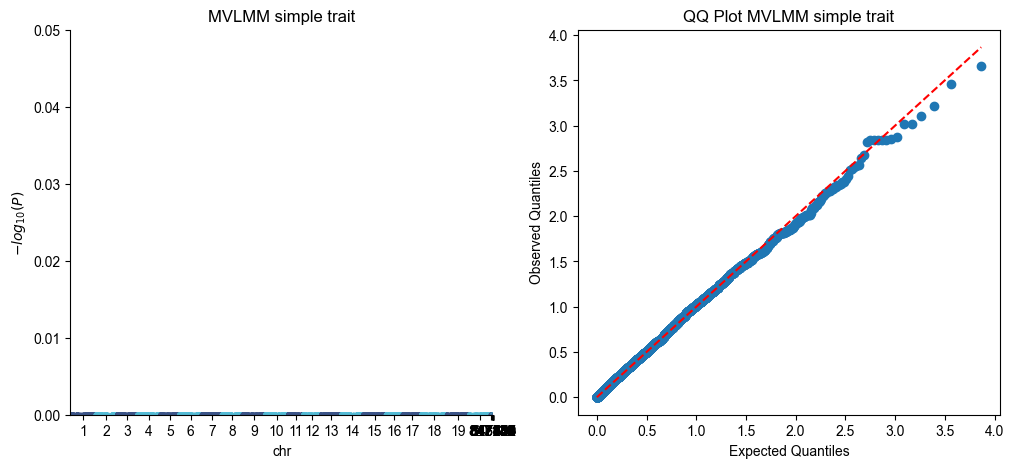

In [54]:
# Read the association results from a text file into a pandas DataFrame
df_soy_simple_m = pd.read_table('GEMMA_MVLMM/output/complex_soy2_mvlmm.assoc.txt', sep="\t")

# Apply the function 'combine_columns' to create a new column named 'rs'
df_soy_simple_m['rs'] = df_soy_simple_m.apply(combine_columns, axis=1)

# Perform false discovery rate correction on the 'p_score' column using the Benjamini-Hochberg method
df_soy_simple_m['P.value_BY'] = stat.fdrcorrection(pvals=df_soy_simple_m['p_score'], 
                                                  alpha=0.1, 
                                                  method='negcorr', 
                                                  is_sorted=False)[1]

# Generate a Manhattan plot and QQ plot using the 'df_soy_simple_m' DataFrame, with plot type 'MVLMM' and 'simple'
manhattan_qq_plot(df_soy_simple_m, 'MVLMM', 'simple');

### MVLMM simple trait generated data

/Users/iskys/venv/lib/python3.9/site-packages/qmplot/modules/_manhattan.py:346: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin=min(y), ymax=1.2 * max(y))


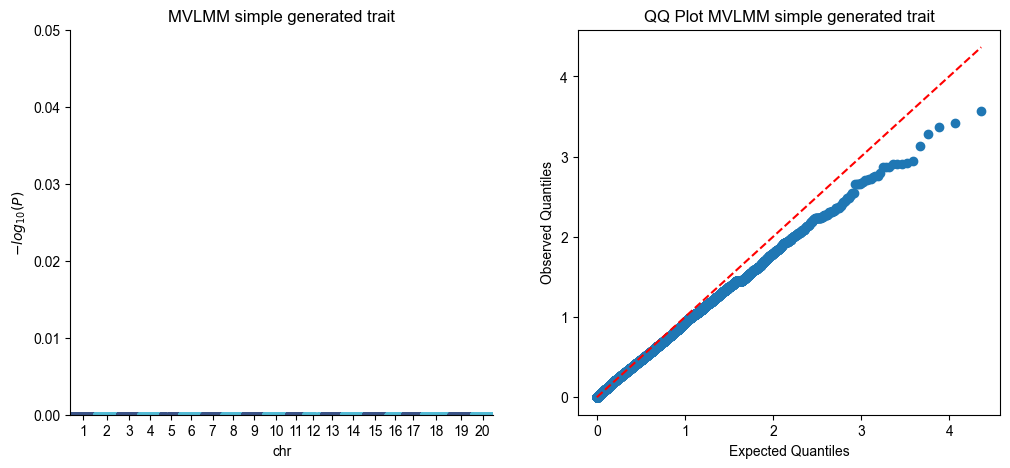

In [55]:
# Read association results from a file into a pandas DataFrame
df_soy_simple_m_gen = pd.read_table('GEMMA_MVLMM/output/simple_soy_gen_mvlmm.assoc.txt', sep="\t")

# Create a new column 'rs' by applying a function combine_columns to each row
df_soy_simple_m_gen['rs'] = df_soy_simple_m_gen.apply(combine_columns, axis=1)

# Perform Benjamini-Hochberg FDR correction on the 'p_score' column and store the corrected p-values
df_soy_simple_m_gen['P.value_BY'] = stat.fdrcorrection(pvals=df_soy_simple_m_gen['p_score'], 
                                                       alpha=0.05, 
                                                       method='negcorr', 
                                                       is_sorted=False)[1]

# Generate a Manhattan plot and QQ plot for the DataFrame
manhattan_qq_plot(df_soy_simple_m_gen, 'MVLMM', 'simple generated');

### MVLMM complex trait

/Users/iskys/venv/lib/python3.9/site-packages/qmplot/modules/_manhattan.py:346: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin=min(y), ymax=1.2 * max(y))


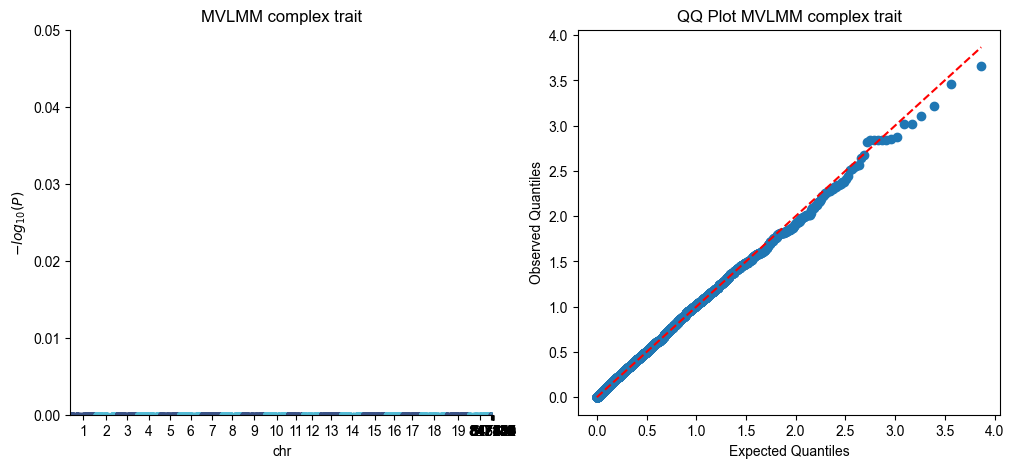

In [56]:
# Read the association results file into a pandas DataFrame
df_soy_complex_m = pd.read_table('GEMMA_MVLMM/output/complex_soy2_mvlmm.assoc.txt', sep="\t")

# Apply the 'combine_columns' function to create a new column called 'rs'
df_soy_complex_m['rs'] = df_soy_complex_m.apply(combine_columns, axis=1)

# Perform FDR correction on the 'p_score' column and assign the corrected p-values to 'P.value_BY'
df_soy_complex_m['P.value_BY'] = stat.fdrcorrection(pvals=df_soy_complex_m['p_score'],
                                                   alpha=0.05,
                                                   method='negcorr',
                                                   is_sorted=False)[1]

# Generate a Manhattan and QQ plot using the 'df_soy_complex_m' DataFrame with the label 'MVLMM' and 'complex'
manhattan_qq_plot(df_soy_complex_m, 'MVLMM', 'complex');

### MVLMM complex trait generated data

/Users/iskys/venv/lib/python3.9/site-packages/qmplot/modules/_manhattan.py:346: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin=min(y), ymax=1.2 * max(y))


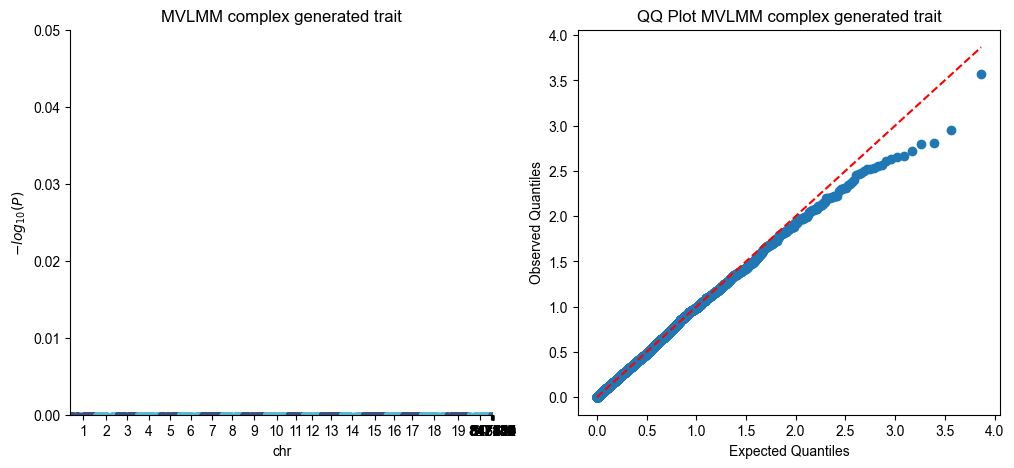

In [57]:
# Read association results from the file 'complex_soy2_gen_mvlmm.assoc.txt' and store it in the DataFrame df_soy_complex_m_gen
df_soy_complex_m_gen = pd.read_table('GEMMA_MVLMM/output/complex_soy2_gen_mvlmm.assoc.txt', sep="\t")

# Apply the function 'combine_columns' to the DataFrame df_soy_complex_m and assign the result to the column 'rs' in df_soy_complex_m_gen
df_soy_complex_m_gen['rs'] = df_soy_complex_m.apply(combine_columns, axis=1)

# Perform FDR correction on the p-values in the column 'p_score' of df_soy_complex_m_gen, with alpha=0.05, using the method 'negcorr'
# Store the corrected p-values in the new column 'P.value_BY'
df_soy_complex_m_gen['P.value_BY'] = stat.fdrcorrection(pvals=df_soy_complex_m_gen['p_score'], 
                                                        alpha=0.05, 
                                                        method='negcorr', 
                                                        is_sorted=False)[1]

# Generate a Manhattan and QQ plot using the DataFrame df_soy_complex_m_gen, labeling it as 'MVLMM' and 'complex generated'
manhattan_qq_plot(df_soy_complex_m_gen, 'MVLMM', 'complex generated');